# POLI/USP Capstone Project
Author: Gabriel Benvegmi

This notebook does the step of data fetching from the B3 (the brazilian stock exchange) website. It gets the published open communications to the market participants, save them as PDFs, and finally converts the PDFs to text and adds them to a Pandas Dataframe.

At the end of the process, some heuristics are calculated in order to find any discrepancies between different Python PDF libraries.

In [1]:
import io
import os
import multiprocessing
import requests
from itertools import combinations
from random import randint
from time import sleep

import matplotlib.pyplot as plt
import pandas as pd
import tqdm
from bs4 import BeautifulSoup
from IPython.display import IFrame

In [2]:
def _fetch_page_content(page_num=1):
    """Fetches page content from B3 website."""
    url = f"https://www.b3.com.br/pt_br/regulacao/oficios-e-comunicados/?pagination={page_num}"
    
    # ToDo - retry on except
    try:
        response = requests.get(url)
    except Exception as e:
        raise e
    
    return BeautifulSoup(response.text, 'html.parser')

In [3]:
def _get_pdf_content(url):
    """Helper function to scrape_b3 function."""
  
      # ToDo - retry on except
      return requests.get(url)

IndentationError: unexpected indent (3108343797.py, line 5)

In [4]:
def scrape_b3(page_num):
    """
    Fetches communications from B3 website using BeautifulSoup.
    This function is prepared to work with multiprocessing in order to
    execute faster.
    """
    # This has been added in order to avoid apparent rate limits.
    # Without this, the process would never end, being stuck at some
    # random pagination number
    if page_num % 5 == 0: 
        sleep(randint(0,10))
        
    save_path = "/home/gabriel/Documentos/projects/poli-capstone-project/data/pdf/"
    soup = _fetch_page_content(page_num)
    content_divs = soup.select('li.accordion-navigation')
    
    base_url = "https://www.b3.com.br"
    data = []

    # For each published communication
    for content in content_divs:
        published_date = content.select("div.least-content")[0].text
        published_title = content.select("div.content p.primary-text")[0].text
        published_abstract = content.select("div.content p.resumo-oficio")[0].text
        published_subject = content.select("div.content p.assunto-oficio")[0].text
        communication_link = content.select("div.content ul li a")[0].get("href", None)
        
        url = base_url + communication_link
        
        pdf_response = _get_pdf_content(url)
        pdf_bytes = pdf_response.content

        file_date = published_date.replace("/", "_")
        file_title = published_title.replace("/", "_")
        file_name = f'{save_path}{file_date}|{file_title}.pdf'

        data.append([published_date, published_title, published_abstract, published_subject, url, file_name])

        with open(file_name, 'wb') as f:
            f.write(pdf_bytes)

        return pd.DataFrame(
            data, 
            columns=[
                "published_date", 
                "published_title", 
                "published_abstract", 
                "published_subject", 
                "url", 
                "file_name"
            ]
        )

In [54]:
num_processes = 4
pagination = [i for i in range(1, 285)] # There are 284 pages as of 2023-10-29

with multiprocessing.Pool(processes=num_processes) as pool:
    results = list(
        tqdm.tqdm(
        pool.imap(scrape_b3, pagination),
        total=len(pagination)
        )
    )

100%|████████████████████████████████████████████████████████████████| 284/284 [04:50<00:00,  1.02s/it]


In [63]:
save_path = "/home/gabriel/Documentos/projects/poli-capstone-project/data/pdf/"
df = pd.concat(results)

df_replaced = df.assign(
    file_name=df["file_name"].str.replace(save_path, "")
)
df_replaced.head()

,published_date,published_title,published_abstract,published_subject,url,file_name
0,26/10/23,174-2023-PRE-Ofício Circular,"Para o presente programa, serão credenciados d...",Processo para Credenciamento no Programa de Fo...,https://www.b3.com.br/data/files/11/52/56/89/C...,26_10_23|174-2023-PRE-Ofício Circular.pdf
0,24/10/23,099-2023-VNC-Comunicado Externo,"A B3 informa que, a partir do dia 30/10/2023, ...",Novos grupos de negociação para operações estr...,https://www.b3.com.br/data/files/AA/D4/F5/61/4...,24_10_23|099-2023-VNC-Comunicado Externo.pdf
0,10/10/23,164-2023-PRE-Ofício Circular,"A B3 informa que, em 16/10/2023, às 15h, será ...",Tratamento das Carteiras de Índices da B3 em v...,https://www.b3.com.br/data/files/58/50/FF/7B/2...,10_10_23|164-2023-PRE-Ofício Circular.pdf
0,05/10/23,051-2023-VPC-Comunicado Externo,"Informamos que, a partir de 15/01/2024, as tab...",Reajuste de Preços dos Serviços de Conectivida...,https://www.b3.com.br/data/files/E4/92/39/AB/6...,05_10_23|051-2023-VPC-Comunicado Externo.pdf
0,28/09/23,090-2023-VNC-Comunicado Externo,A B3 informa que está disponível para download...,Gateway Binário – Atualização do Template,https://www.b3.com.br/data/files/3B/61/7B/62/9...,28_09_23|090-2023-VNC-Comunicado Externo.pdf


In [65]:
# Checkpoint
df_replaced.to_parquet("../data/list_b3.parquet", engine="pyarrow")

In [89]:
from pypdf import PdfReader

def extract_text_with_pypdf(dataframe_row):
    save_path = "/home/gabriel/Documentos/projects/poli-capstone-project/data/pdf/"
    file_name = dataframe_row
    
    with open(f'{save_path}{file_name}', "rb") as pdf_file:
        reader = PdfReader(pdf_file)
        pages = reader.pages
        
        full_text = ""
        for page in pages:
          full_text += page.extract_text()

    return full_text

In [91]:
df_replaced['pypdf_extraction'] = df_replaced["file_name"].apply(extract_text_with_pypdf)
df_replaced.tail()

,published_date,published_title,published_abstract,published_subject,url,file_name,pypdf_extraction
0,10/05/17,034-2017-DP-Ofício Circular,"O tratamento, pelo Serviço de Empréstimo de At...",Tratamento das Posições de Empréstimo de Ativo...,https://www.b3.com.br/data/files/42/A7/73/6D/9...,10_05_17|034-2017-DP-Ofício Circular.pdf,\n \n 1 \n10 de maio de 201 7 \n034/2017 ...
0,13/04/17,031-2017-DP-Ofício Circular,A B3 informa o início do Processo para Credenc...,Processo para Credenciamento de Formador de Me...,https://www.b3.com.br/data/files/69/47/DB/65/0...,13_04_17|031-2017-DP-Ofício Circular.pdf,\n \n 1 \n13 de abril de 201 7 \n031/2017...
0,29/03/17,027-2017-DP-Ofício Circular,"A Bolsa implementará, em sua plataforma PUMA T...",Plataforma PUMA Trading System B3 – Implementa...,https://www.b3.com.br/data/files/B9/91/AD/B1/9...,29_03_17|027-2017-DP-Ofício Circular.pdf,\n 1 \n \n \n \n \n \n29 de março de 201...
0,23/03/17,025-2017-DO-Comunicado Externo,"Em 24/03/2017, o Banco Itaú BBA S.A. realizará...",Distribuição Pública Primária e Secundária de ...,https://www.b3.com.br/data/files/7D/33/FA/A1/4...,23_03_17|025-2017-DO-Comunicado Externo.pdf,\n \n23 de março de 2017 \n025/2017 -DO \nC...
0,31/05/12,081-2012DO-Comunicado Externo,"A BM&FBOVESPA oferecerá, a partir de 04/06/201...",Transferência de Proventos Provisionados e Man...,https://www.b3.com.br/data/files/B1/B4/76/24/F...,31_05_12|081-2012DO-Comunicado Externo.pdf,


In [100]:
# entries that are empty
df_replaced[df_replaced["pypdf_extraction"].apply(len) <= 5]

,published_date,published_title,published_abstract,published_subject,url,file_name,pypdf_extraction
0,18/04/19,004-2019-VPC-Ofício Circular,Informamos o lançamento da Política Comercial ...,Market Data B3 – Nova Política Comercial de Di...,https://www.b3.com.br/data/files/2E/D4/94/79/5...,18_04_19|004-2019-VPC-Ofício Circular.pdf,
0,31/05/12,081-2012DO-Comunicado Externo,"A BM&FBOVESPA oferecerá, a partir de 04/06/201...",Transferência de Proventos Provisionados e Man...,https://www.b3.com.br/data/files/B1/B4/76/24/F...,31_05_12|081-2012DO-Comunicado Externo.pdf,


In [101]:
df_replaced.to_parquet("../data/list_b3_pdf_comparison.parquet", engine="pyarrow")

The pdfminer library will be tested. The <a href="https://github.com/euske/pdfminer">main</a> library appear to be dormant currently, and it's recommended in their github page to use <a href="https://github.com/pdfminer/pdfminer.six">pdfminer.six</a>. So, this version will be the tested one.
Also, based on recent benchmarks presented over this benchmarks <a href="https://github.com/py-pdf/benchmarks">repo</a> on Github, pypdfium2 will also be tested, as it's the library that presents the best results over the benchmarks there.

In [107]:
from pdfminer.high_level import extract_text

def extract_text_with_pdfminer(dataframe_row):
    save_path = "/home/gabriel/Documentos/projects/poli-capstone-project/data/pdf/"
    file_name = dataframe_row
    
    full_text = extract_text(f'{save_path}{file_name}')
    return full_text

In [108]:
df_replaced['pdfminer_extraction'] = df_replaced["file_name"].apply(extract_text_with_pdfminer)
df_replaced.tail()

,published_date,published_title,published_abstract,published_subject,url,file_name,pypdf_extraction,pdfminer_extraction
0,10/05/17,034-2017-DP-Ofício Circular,"O tratamento, pelo Serviço de Empréstimo de At...",Tratamento das Posições de Empréstimo de Ativo...,https://www.b3.com.br/data/files/42/A7/73/6D/9...,10_05_17|034-2017-DP-Ofício Circular.pdf,\n \n 1 \n10 de maio de 201 7 \n034/2017 ...,10 de maio de 2017 \n\n034/2017-DP \n\nO F Í C...
0,13/04/17,031-2017-DP-Ofício Circular,A B3 informa o início do Processo para Credenc...,Processo para Credenciamento de Formador de Me...,https://www.b3.com.br/data/files/69/47/DB/65/0...,13_04_17|031-2017-DP-Ofício Circular.pdf,\n \n 1 \n13 de abril de 201 7 \n031/2017...,13 de abril de 2017 \n\n031/2017-DP \n\nO F Í ...
0,29/03/17,027-2017-DP-Ofício Circular,"A Bolsa implementará, em sua plataforma PUMA T...",Plataforma PUMA Trading System B3 – Implementa...,https://www.b3.com.br/data/files/B9/91/AD/B1/9...,29_03_17|027-2017-DP-Ofício Circular.pdf,\n 1 \n \n \n \n \n \n29 de março de 201...,29 de março de 2017 \n\n027/2017-DP \n\nO F Í ...
0,23/03/17,025-2017-DO-Comunicado Externo,"Em 24/03/2017, o Banco Itaú BBA S.A. realizará...",Distribuição Pública Primária e Secundária de ...,https://www.b3.com.br/data/files/7D/33/FA/A1/4...,23_03_17|025-2017-DO-Comunicado Externo.pdf,\n \n23 de março de 2017 \n025/2017 -DO \nC...,23 de março de 2017 \n025/2017-DO \n\nC O M U ...
0,31/05/12,081-2012DO-Comunicado Externo,"A BM&FBOVESPA oferecerá, a partir de 04/06/201...",Transferência de Proventos Provisionados e Man...,https://www.b3.com.br/data/files/B1/B4/76/24/F...,31_05_12|081-2012DO-Comunicado Externo.pdf,,


In [109]:
# entries that are empty: same between the different libraries
df_replaced[df_replaced["pdfminer_extraction"].apply(len) <= 5]

,published_date,published_title,published_abstract,published_subject,url,file_name,pypdf_extraction,pdfminer_extraction
0,18/04/19,004-2019-VPC-Ofício Circular,Informamos o lançamento da Política Comercial ...,Market Data B3 – Nova Política Comercial de Di...,https://www.b3.com.br/data/files/2E/D4/94/79/5...,18_04_19|004-2019-VPC-Ofício Circular.pdf,,
0,31/05/12,081-2012DO-Comunicado Externo,"A BM&FBOVESPA oferecerá, a partir de 04/06/201...",Transferência de Proventos Provisionados e Man...,https://www.b3.com.br/data/files/B1/B4/76/24/F...,31_05_12|081-2012DO-Comunicado Externo.pdf,,


In [110]:
# another checkpoint
df_replaced.to_parquet("../data/list_b3_pdf_comparison.parquet", engine="pyarrow")

In [126]:
import pypdfium2 as pdfium

def extract_text_with_pypdfium(dataframe_row):
    save_path = "/home/gabriel/Documentos/projects/poli-capstone-project/data/pdf/"
    file_name = dataframe_row
    
    with open(f'{save_path}{file_name}', "rb") as pdf_file:
        pdf = pdfium.PdfDocument(f"{save_path}{file_name}")
        
        full_text = ""
        for page in pdf:
            textpage = page.get_textpage()
            full_text += textpage.get_text_range()
        
    return full_text

In [128]:
df_replaced['pypdfium_extraction'] = df_replaced["file_name"].apply(extract_text_with_pypdfium)
df_replaced.tail()

,published_date,published_title,published_abstract,published_subject,url,file_name,pypdf_extraction,pdfminer_extraction,pypdfium_extraction
0,10/05/17,034-2017-DP-Ofício Circular,"O tratamento, pelo Serviço de Empréstimo de At...",Tratamento das Posições de Empréstimo de Ativo...,https://www.b3.com.br/data/files/42/A7/73/6D/9...,10_05_17|034-2017-DP-Ofício Circular.pdf,\n \n 1 \n10 de maio de 201 7 \n034/2017 ...,10 de maio de 2017 \n\n034/2017-DP \n\nO F Í C...,1\r\n10 de maio de 2017\r\n034/2017-DP\r\nO F ...
0,13/04/17,031-2017-DP-Ofício Circular,A B3 informa o início do Processo para Credenc...,Processo para Credenciamento de Formador de Me...,https://www.b3.com.br/data/files/69/47/DB/65/0...,13_04_17|031-2017-DP-Ofício Circular.pdf,\n \n 1 \n13 de abril de 201 7 \n031/2017...,13 de abril de 2017 \n\n031/2017-DP \n\nO F Í ...,1\r\n13 de abril de 2017\r\n031/2017-DP\r\nO F...
0,29/03/17,027-2017-DP-Ofício Circular,"A Bolsa implementará, em sua plataforma PUMA T...",Plataforma PUMA Trading System B3 – Implementa...,https://www.b3.com.br/data/files/B9/91/AD/B1/9...,29_03_17|027-2017-DP-Ofício Circular.pdf,\n 1 \n \n \n \n \n \n29 de março de 201...,29 de março de 2017 \n\n027/2017-DP \n\nO F Í ...,1\r\n29 de março de 2017\r\n027/2017-DP\r\nO F...
0,23/03/17,025-2017-DO-Comunicado Externo,"Em 24/03/2017, o Banco Itaú BBA S.A. realizará...",Distribuição Pública Primária e Secundária de ...,https://www.b3.com.br/data/files/7D/33/FA/A1/4...,23_03_17|025-2017-DO-Comunicado Externo.pdf,\n \n23 de março de 2017 \n025/2017 -DO \nC...,23 de março de 2017 \n025/2017-DO \n\nC O M U ...,23 de março de 2017\r\n025/2017-DO\r\nC O M U ...
0,31/05/12,081-2012DO-Comunicado Externo,"A BM&FBOVESPA oferecerá, a partir de 04/06/201...",Transferência de Proventos Provisionados e Man...,https://www.b3.com.br/data/files/B1/B4/76/24/F...,31_05_12|081-2012DO-Comunicado Externo.pdf,,,


In [129]:
# entries that are empty: still the ame between the different libraries
df_replaced[df_replaced["pypdfium_extraction"].apply(len) <= 5]

,published_date,published_title,published_abstract,published_subject,url,file_name,pypdf_extraction,pdfminer_extraction,pypdfium_extraction
0,18/04/19,004-2019-VPC-Ofício Circular,Informamos o lançamento da Política Comercial ...,Market Data B3 – Nova Política Comercial de Di...,https://www.b3.com.br/data/files/2E/D4/94/79/5...,18_04_19|004-2019-VPC-Ofício Circular.pdf,,,
0,31/05/12,081-2012DO-Comunicado Externo,"A BM&FBOVESPA oferecerá, a partir de 04/06/201...",Transferência de Proventos Provisionados e Man...,https://www.b3.com.br/data/files/B1/B4/76/24/F...,31_05_12|081-2012DO-Comunicado Externo.pdf,,,


In [130]:
# yet another checkpoint
df_replaced.to_parquet("../data/list_b3_pdf_comparison.parquet", engine="pyarrow")

Let's count the size of the texts to search any discrepances.

In [135]:
libs = ["pypdf", "pdfminer", "pypdfium"]

for lib in libs:
    df_replaced[f"{lib}_str_len"] = df_replaced[f"{lib}_extraction"].str.len()

In [146]:
# Now, let's analyze how the text sizer differ between the libraries
for lib_1, lib_2 in combinations(libs, 2):
    df_replaced[f"{lib_1}_{lib_2}_diff"] = abs(df_replaced[f"{lib_1}_str_len"] - df_replaced[f"{lib_2}_str_len"] )

<Axes: >

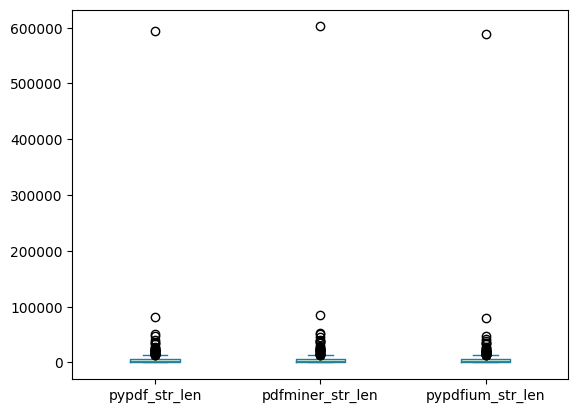

In [154]:
df_replaced[["pypdf_str_len", "pdfminer_str_len", "pypdfium_str_len"]].plot(kind="box")

In [21]:
df_replaced = pd.read_parquet("../data/list_b3_pdf_comparison.parquet", engine="pyarrow")
df_replaced.reset_index(drop=True, inplace=True)

In [30]:
idx = 0

file = df_replaced.loc[idx,"file_name"]
pypdf_snippet = df_replaced.loc[idx,"pypdf_extraction"]
pdfminer_snippet = df_replaced.loc[idx,"pdfminer_extraction"]
pypdfium_snippet = df_replaced.loc[idx,"pypdfium_extraction"]

IFrame(f"../data/pdf/{file}", width=800, height=1000)

In [29]:
print(pypdf_snippet)

 
 
Este documento produz efeitos a partir da data de sua publicação, respeitados os prazos específicos de vigência, se houver.  
O teor deste documento confere com o original assinado, disponível na B3.  
Praça Antonio Prado, 48 – 01010 -901 – São Paulo, SP | Tel.: (11) 2565 -4000 – Fax: (11) 2565 -7737  1 
INFORMAÇÃO PÚBLICA – PUBLIC INFORMATION  26 de outubro de 2023  
174/2023 -PRE  
OFÍCIO CIRCULAR  
Participantes do Listado B3  
Ref.: Processo para Credenciamento no Programa de Formador de 
Mercado para Opções sobre Ações , Units e ETFs  – Tranche de 
Dezembro  
Para o presente programa, serão credenciados de 5 (cinco) a  7 (sete) formadores 
de mercado para as opções dos ativos, conforme relacionado abaixo.  
A B3 poderá, a seu exclusivo critério, aumentar o número de vagas disponíveis 
para credenciamento, limitado a 10 vagas por ativo, as instituições serão 
selecionadas de acordo com o ranking desse processo de seleção, conforme os 
Anexos deste Ofício Circular . 
Ambev S.A. 

In [28]:
print(pdfminer_snippet)

26 de outubro de 2023 
174/2023-PRE  

OFÍCIO CIRCULAR 

Participantes do Listado B3  

Ref.:  Processo  para  Credenciamento  no  Programa  de  Formador  de 

Mercado  para  Opções  sobre  Ações,  Units  e  ETFs  –  Tranche  de 

Dezembro 

Para o presente programa, serão credenciados de 5 (cinco) a 7 (sete) formadores 

de mercado para as opções dos ativos, conforme relacionado abaixo.  

A B3 poderá, a seu exclusivo critério, aumentar o número de vagas disponíveis 

para  credenciamento,  limitado  a  10  vagas  por  ativo,  as  instituições  serão 

selecionadas de acordo com o ranking desse processo de seleção, conforme os 

Anexos deste Ofício Circular. 

Ambev S.A. (ABEV3) 

Iguatemi S.A. (IGTI11) 

Alpargatas S.A. (ALPA4) 

Itaú Unibanco Holding S.A. (ITUB4) 

Aliansce Sonae Shopping Centers S.A. 
(ALOS3) 

JBS S.A. (JBSS3) 

Arezzo Indústria e Comércio S.A. (ARZZ3) 

JHSF Participações S.A. (JHSF3) 

Sendas Distribuidora S.A. (ASAI3) 

Klabin S.A. (KLBN11) 

B3 S.A. – Brasil, 

In [27]:
print(pypdfium_snippet)

Este documento produz efeitos a partir da data de sua publicação, respeitados os prazos específicos de vigência, se houver.
O teor deste documento confere com o original assinado, disponível na B3.
Praça Antonio Prado, 48 – 01010-901 – São Paulo, SP | Tel.: (11) 2565-4000 – Fax: (11) 2565-7737
1
INFORMAÇÃO PÚBLICA – PUBLIC INFORMATION
26 de outubro de 2023
174/2023-PRE
OFÍCIO CIRCULAR
Participantes do Listado B3 
Ref.: Processo para Credenciamento no Programa de Formador de 
Mercado para Opções sobre Ações, Units e ETFs – Tranche de 
Dezembro
Para o presente programa, serão credenciados de 5 (cinco) a 7 (sete) formadores 
de mercado para as opções dos ativos, conforme relacionado abaixo. 
A B3 poderá, a seu exclusivo critério, aumentar o número de vagas disponíveis 
para credenciamento, limitado a 10 vagas por ativo, as instituições serão 
selecionadas de acordo com o ranking desse processo de seleção, conforme os 
Anexos deste Ofício Circular.
Ambev S.A. (ABEV3) Iguatemi S.A. (IGTI11)

In [34]:
idx = 2

file = df_replaced.loc[idx,"file_name"]
pypdf_snippet = df_replaced.loc[idx,"pypdf_extraction"]
pdfminer_snippet = df_replaced.loc[idx,"pdfminer_extraction"]
pypdfium_snippet = df_replaced.loc[idx,"pypdfium_extraction"]

IFrame(f"../data/pdf/{file}", width=800, height=1000)

In [37]:
print(pypdf_snippet)

 
 
 
 
Este documento produz efeitos a partir da data de sua publicação, respeitados os prazos específicos de vigência, se houver.  
O teor deste documento confere com o original assinado, disponível na B3.  
Praça Antonio Prado, 48 – 01010 -901 – São Paulo, SP | Tel.: (11) 2565 -4000 – Fax: (11) 2565 -7737  1 
INFORMAÇÃO PÚBLICA – PUBLIC INFORMATION  10 de outubro de 2023  
164/2023-PRE 
OFÍCIO CIRCULAR  
Participantes do Listado B3  
Ref.: Tratamento das Carteiras de Índices da B3 em virtude de OPA da BR 
Properties  S.A. 
A B3 informa que , em 16/10/2023 , às 15h, será realizad o o leilão  da Oferta 
Pública de Aquisição (OPA) de ações ordinárias  para cancelamento de registro da 
BR Properties  S.A. (Companhia).  De acordo com  Edital publicado em 15/09/2023 , 
a Slabs Investimentos Ltda.  (Ofertante ) se dispõe a adquirir até 17.205  (dezessete 
mil, duzentas e cinco ) ações ordinárias de emissão da Companhia (BRPR 3). Com 
base na Decisão CVM, descrita no item 2.4 do Edital, o s

In [36]:
print(pdfminer_snippet)

10 de outubro de 2023 
164/2023-PRE 

OFÍCIO CIRCULAR 

Participantes do Listado B3  

Ref.:  Tratamento das Carteiras de Índices da B3 em virtude de OPA da BR 

Properties S.A. 

A  B3  informa  que,  em  16/10/2023,  às  15h,  será  realizado  o  leilão  da  Oferta 

Pública de Aquisição (OPA) de ações ordinárias para cancelamento de registro da 

BR Properties S.A. (Companhia). De acordo com Edital publicado em 15/09/2023, 

a Slabs Investimentos Ltda. (Ofertante) se dispõe a adquirir até 17.205 (dezessete 

mil, duzentas e cinco) ações ordinárias de emissão da Companhia (BRPR3). Com 

base na Decisão CVM, descrita no item 2.4 do Edital, o sucesso da oferta deve ser 

considerado desde já atingido. 

Procedimentos nas carteiras de índices 

1.  Para os índices GPTW B3 (GPTW), Brasil Amplo BM&FBOVESPA (IBRA), Índice 

Imobiliário  (IMOB),  Índices  de  Ações  com  Tag  Along  Diferenciado  (ITAG)  e 

Small  Cap  (SMLL),  a  ação  BRPR3  será  excluída  da  carteira  teórica  após  o

In [41]:
# file = df_replaced.loc[idx,"file_name"]
# pypdf_snippet = df_replaced.loc[idx,"pypdf_extraction"]
# pdfminer_snippet = df_replaced.loc[idx,"pdfminer_extraction"]
# pypdfium_snippet = df_replaced.loc[idx,"pypdfium_extraction"]
file

'10_10_23|164-2023-PRE-Ofício Circular.pdf'

In [47]:
df_replaced.iloc[2,:]["published_title"]

'164-2023-PRE-Ofício Circular'

In [35]:
print(pypdfium_snippet)

Este documento produz efeitos a partir da data de sua publicação, respeitados os prazos específicos de vigência, se houver.
O teor deste documento confere com o original assinado, disponível na B3.
Praça Antonio Prado, 48 – 01010-901 – São Paulo, SP | Tel.: (11) 2565-4000 – Fax: (11) 2565-7737
1
INFORMAÇÃO PÚBLICA – PUBLIC INFORMATION
10 de outubro de 2023
164/2023-PRE
OFÍCIO CIRCULAR
Participantes do Listado B3 
Ref.: Tratamento das Carteiras de Índices da B3 em virtude de OPA da BR 
Properties S.A.
A B3 informa que, em 16/10/2023, às 15h, será realizado o leilão da Oferta 
Pública de Aquisição (OPA) de ações ordinárias para cancelamento de registro da 
BR Properties S.A. (Companhia). De acordo com Edital publicado em 15/09/2023, 
a Slabs Investimentos Ltda. (Ofertante) se dispõe a adquirir até 17.205 (dezessete 
mil, duzentas e cinco) ações ordinárias de emissão da Companhia (BRPR3). Com 
base na Decisão CVM, descrita no item 2.4 do Edital, o sucesso da oferta deve ser 
considerado d